# Differentiation

Recall that a derivative measures the rate of change in a function
\begin{equation}
\frac{df}{dx} = \lim_{h\to 0} \frac{f(x+h) - f(x)}{h}
\end{equation}

Or we can write symmetrically
\begin{equation}
\frac{df}{dx} = \lim_{h\to 0+} \frac{f(x+h) - f(x-h)}{2h}
\end{equation}

When we have a function of more than one variable, we can take partial derivatives
\begin{equation}
\frac{\partial f}{\partial x_i} = \lim_{h\to 0} \frac{f(x+h e_i) - f(x)}{h}
\end{equation}
where $e_i$ is the vector with a 1 in the $i$th entry and 0 elsewhere.

The **gradient** of $f$ is the vector
\begin{equation}
\nabla f = \bigg[ \frac{\partial f}{\partial x_0}, \frac{\partial f}{\partial x_1}, \dots \bigg]^T
\end{equation}

The **Hessian** of $f$ is the symmetric matrix $H$, where
\begin{equation}
H[i,j] = \frac{\partial^2 f}{\partial x_i \partial x_j}
\end{equation}

## Symbolic Differentiation

Let's consider the function
\begin{equation}
f(x) = \exp(-(x^2 - x - 1)^2)
\end{equation}

In principle, we could calculate the derivative of $f$ with respect to $x$ using rules learned in calculus, however, we'll just use `sympy`

In [1]:
import sympy as sym
x = sym.symbols('x')
f = sym.exp(-(x**2 - x - 1)**2)
f

exp(-(x**2 - x - 1)**2)

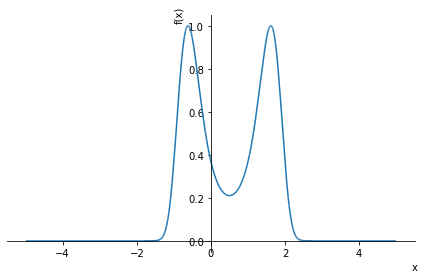

In [2]:
fig = sym.plot(f, (x, -5, 5))

In [3]:
f1 = sym.diff(f, x)
f1

-(4*x - 2)*(x**2 - x - 1)*exp(-(x**2 - x - 1)**2)

There we go.  We probably could have done that by hand without too much trouble

It is just as easy to take a second derivative.

In [4]:
f2 = sym.diff(f1, x)
f2

(2 - 4*x)*(2*x - 1)*exp(-(x**2 - x - 1)**2) - (2 - 4*x)*(4*x - 2)*(x**2 - x - 1)**2*exp(-(x**2 - x - 1)**2) + (-4*x**2 + 4*x + 4)*exp(-(x**2 - x - 1)**2)

This probably would have been a bit of a pain to do by hand.

We can see if there's a good way to simplify the expression using sympy:

In [5]:
sym.factor(sym.expand(f2))

2*(8*x**6 - 24*x**5 + 10*x**4 + 20*x**3 - 16*x**2 + 2*x + 3)*exp(-1)*exp(-2*x)*exp(x**2)*exp(2*x**3)*exp(-x**4)

Now, let's plot

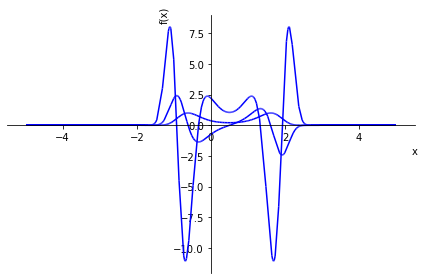

In [6]:
sym.plot(f, f1, f2, (x, -5, 5), line_color='b')

## Numerical Differentiation

Numerical differentiation approximates the derivative instead of obtaining an exact expression.

In [8]:
g = sym.lambdify(x, f, 'numpy') # get lambda function for numerical evaluation

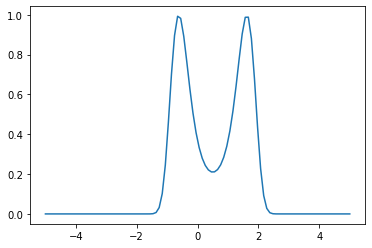

In [9]:
import numpy as np
import matplotlib.pyplot as plt
xs = np.linspace(-5,5,100)
plt.plot(xs, g(xs))
plt.show()

The most straightforward way to obtain an approximation is to return to the definition of derivative in terms of a limit.  Because we can not take $h$ arbitrarily close to zero, we'll just choose a suitably small value of $h$.  $\sqrt{\epsilon}$ (about $10^{-8}$ in double precision) is often a good starting point.

An approximation of the derivative in this way is called a finite difference scheme.

Because we don't actually reach the limit, there are several ways we might actually implement this (assume $h > 0$).
* A forward difference - $f'(x) \approx \frac{f(x + h) - f(x)}{h}$
* A backward difference - $f'(x) \approx \frac{f(x) - f(x-h)}{h}$
* A central difference - $f'(x) \approx \frac{f(x + h) - f(x - h)}{2h}$

Each of these will generally give a slightly different result

In [10]:
from numpy import exp

def forward_difference(g, x, h):
    return (g(x + h) - g(x)) / h

def backward_difference(g, x, h):
    return (g(x) - g(x-h)) / h

def central_difference(g, x, h):
    return (g(x+h) - g(x - h)) / (2*h)

x0 = 1.0
h = 1e-8
for diff in [forward_difference, backward_difference, central_difference]:
    print("{} : {}".format(diff.__name__, diff(g, x0, h)))

forward_difference : 0.7357588815981586
backward_difference : 0.7357588704959284
central_difference : 0.7357588760470435


evaluating the exact expression gives

In [11]:
f1.evalf(subs={x: x0})

0.735758882342885

### Exercise

Evaluate each difference scheme at $x =1.0$ for logarithmically spaced values of $h$ between $10^{-2}$ and $10^{-16}$.  Make a plot of the error with $h$ compared to the exact expression, with $h$ on the horizontal axis.

In [11]:
## Your code here


## Numerical Differentiation on a Grid

Suppose we have evaluated a function on a grid

In [12]:
xs = np.linspace(-5, 5, 100)
h = 10/99
gx = g(xs)

What if we want to evaluate the derivative at each point on the grid?

`numpy` provides a function to efficiently compute this using differences: `diff`. This is equivalent to
```python
np.array([gx[i+1] - gx[i] for i in range(len(gx) - 1)])
```
In order to approximate the derivative using a forward difference, we need to then divide by `h`.  Note that the resulting array will have one less entry than the input.

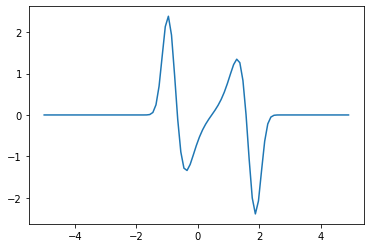

In [13]:
gx1 = np.diff(gx)/h
plt.plot(xs[:-1], gx1)
plt.show()

Note that finite difference schemes are linear operators on vectors of functions evaluated on an equispaced grid.  This means we can represent them as (sparse) matrices.

In [14]:
import scipy.sparse as sparse

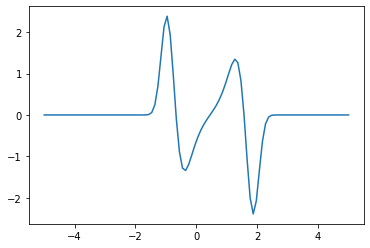

In [18]:
# create matrix A to apply forward difference scheme
def forward_diff_matrix(n):
    data = []
    i = []
    j = []
    for k in range(n - 1):
        i.append(k)
        j.append(k)
        data.append(-1)

        i.append(k)
        j.append(k+1)
        data.append(1)
        
    # we'll just set the last entry to 0 to have a square matrix
    return sparse.coo_matrix((data, (i,j)), shape=(n, n)).tocsr()
    
D = forward_diff_matrix(len(gx)) / h
gx1 = D@gx
plt.plot(xs, gx1)
plt.show()

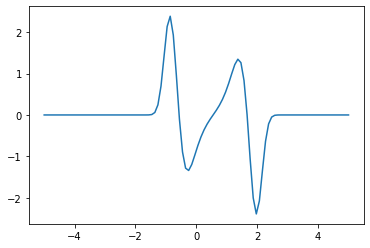

In [19]:
# create matrix A to apply forward difference scheme
def backward_diff_matrix(n):
    data = []
    i = []
    j = []
    for k in range(1,n):
        i.append(k)
        j.append(k)
        data.append(1)

        i.append(k)
        j.append(k-1)
        data.append(-1)
        
    # we'll just set the last entry to 0 to have a square matrix
    return sparse.coo_matrix((data, (i,j)), shape=(n, n)).tocsr()

D = backward_diff_matrix(len(gx)) / h
gx1 = D*gx
plt.plot(xs, gx1)
plt.show()

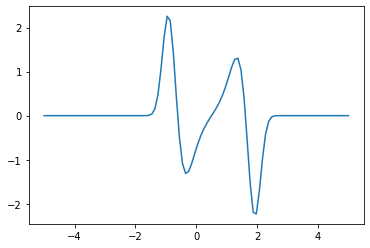

In [20]:
# create matrix A to apply central difference scheme
def central_diff_matrix(n):
    data = []
    i = []
    j = []
    for k in range(1,  n - 1):
        i.append(k)
        j.append(k-1)
        data.append(-1)

        i.append(k)
        j.append(k+1)
        data.append(1)
        
    return sparse.coo_matrix((data, (i,j)), shape=(n,n)).tocsr() 
    
D1 = central_diff_matrix(len(gx)) / (2*h)
gx1 = D1*gx
plt.plot(xs, gx1)
plt.show()

Note that central difference schemes can't compute a derivative at the two end points.

One way we might compute a derivative for all points on the grid (including the end points) is to use
1. a central difference scheme in the interior.
2. a forward difference on the left
3. a backward difference on the right

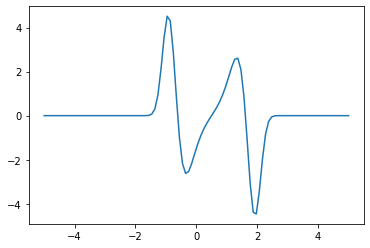

In [21]:
def diff_matrix(n):
    """
    Create a matrix that acts as a finite difference derivative on vector of length n
    """
    data = []
    i = []
    j = []

    # forward difference
    i.append(0)
    j.append(0)
    data.append(-1)

    i.append(0)
    j.append(1)
    data.append(1)

    # central differences in interior
    for k in range(1, n - 1):
        i.append(k)
        j.append(k-1)
        data.append(-1)

        i.append(k)
        j.append(k+1)
        data.append(1)

    # backward difference
    i.append(n-1)
    j.append(n-1)
    data.append(1)

    i.append(n-1)
    j.append(n-2)
    data.append(-1)
    
    return sparse.coo_matrix((data, (i,j)), shape=(n, n)).tocsr()

D1 = diff_matrix(len(gx)) / h
gx1 = D1*gx
plt.plot(xs, gx1)
plt.show()

## Higher Order Derivatives

For simplicity, we'll use the square difference operator we defined above, and we'll remove the scaling by `h`.

In [22]:
D1 = diff_matrix(len(gx))

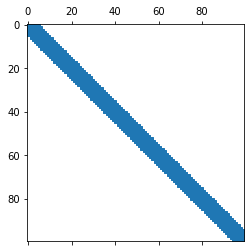

In [23]:
plt.spy(D1)

Because differentiation is a linear operator, we can compute higher order derivatives by repeatedly applying the differentiation operator.

In [25]:
# second derivative 
D2 = D1 @ D1

In [26]:
# third derivative
D3 = D1 @ D2

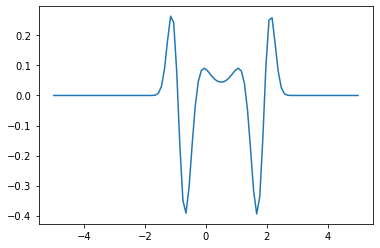

In [27]:
gx2 = D2 @ gx
plt.plot(xs, gx2)
plt.show()

Let's inspect the entries of the second-order derivative matrix

In [28]:
D2[:8,:8].todense()

matrix([[ 0, -1,  1,  0,  0,  0,  0,  0],
        [ 1, -2,  0,  1,  0,  0,  0,  0],
        [ 1,  0, -2,  0,  1,  0,  0,  0],
        [ 0,  1,  0, -2,  0,  1,  0,  0],
        [ 0,  0,  1,  0, -2,  0,  1,  0],
        [ 0,  0,  0,  1,  0, -2,  0,  1],
        [ 0,  0,  0,  0,  1,  0, -2,  0],
        [ 0,  0,  0,  0,  0,  1,  0, -2]])

After the first few rows, we see a recurring pattern, where 
```python
[1, 0, -2, 0, 1]
```
repeats along the diagonal.  This is a stencil for a second derivative, based on squaring a central difference.

We can derive a different stencil for second derivatives by applying a forward difference operator to the backward difference operator:

In [29]:
D2 = forward_diff_matrix(len(gx)) @ backward_diff_matrix(len(gx))
D2[:8,:8].todense()

matrix([[-1,  1,  0,  0,  0,  0,  0,  0],
        [ 1, -2,  1,  0,  0,  0,  0,  0],
        [ 0,  1, -2,  1,  0,  0,  0,  0],
        [ 0,  0,  1, -2,  1,  0,  0,  0],
        [ 0,  0,  0,  1, -2,  1,  0,  0],
        [ 0,  0,  0,  0,  1, -2,  1,  0],
        [ 0,  0,  0,  0,  0,  1, -2,  1],
        [ 0,  0,  0,  0,  0,  0,  1, -2]])

Now, we see the recurring pattern
```python
[1, -2, 1]
```
Along the diagonal.

### Exercise

1. Create a second-order difference from a backward difference applied to a forward difference.  Is this different from the second-order difference operator above?

In [26]:
## Your code here


In general, you may wish to define a second-order difference stencil that more naturally maps a discrete function on `n` points to a discrete function on `n` points.  In this situation, we can interpret the second derivative as a diffusion operator.  In this situation, you would use $-\partial^T \partial$ where $\partial$ is a first-order difference.

In [29]:
D1 = forward_diff_matrix(len(gx))
D2 = -D1.T @ D1
print(D2[:4,:4].todense())
print(D2[-4:,-4:].todense())

[[-1  1  0  0]
 [ 1 -2  1  0]
 [ 0  1 -2  1]
 [ 0  0  1 -2]]
[[-2  1  0  0]
 [ 1 -2  1  0]
 [ 0  1 -2  1]
 [ 0  0  1 -1]]


does the above result rely on the choice of `forward_diff_matrix` vs `backward_diff_matrix`?

In [28]:
## Your code here


## Higher Dimensional Grids

What if we want to compute partial derivatives on higher-dimensional grids?

We want to create an operator that will act as a derivative on the function treated as a vector.

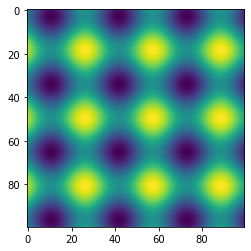

In [32]:
x = np.linspace(-10,10,100)
y = np.linspace(-10,10,100)
xx, yy = np.meshgrid(x, y) # xx[i,j] = x[j], yy[i,j] = y[i]
g2d = np.sin(xx) + np.cos(yy) # g2d[i,j] = sin(x[j]) + cos(y[i])

# # this is equivalent
# for j in range(len(x)):
#     for i in range(len(y)):
#         g2d[i,j] = np.sin(x[j]) + np.cos(y[i])
        
plt.imshow(g2d)
plt.show()

In [31]:
np.meshgrid(np.linspace(-1,1,3), np.linspace(-1,1,3))

[array([[-1.,  0.,  1.],
        [-1.,  0.,  1.],
        [-1.,  0.,  1.]]),
 array([[-1., -1., -1.],
        [ 0.,  0.,  0.],
        [ 1.,  1.,  1.]])]

In [37]:
# turn 2-dimensional function to a vector
g = g2d.flatten()

Recall that numpy arrays are row-major by default.  This means that if we want to compute derivatives along the x axis, we can simply create a block matrix with a derivative operator for in each block for a contiguous row.

`numpy.sparse.kron` is a very useful function to create such a sparse matrix

`kron(A,B)` computes the [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) $A \otimes B$.  If $A$ is a $m\times n$ matrix and $B$ is a $p\times q$ matrix, then $A \otimes B$ is a $(mp) \times (nq)$ matrix which we can define in terms of a $m\times n$ grid of $p\times q$ blocks.  The $i,j$ block has the form $A[i,j] B$ (the matrix $B$ scaled by $A[i,j]$).

If we want to create the numerical operator $\partial_x$ (i.e. differentiation in the row-major direction), we can use the following construction:

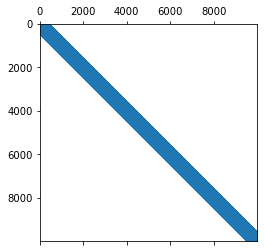

In [35]:
D = diff_matrix(100)
Dx = sparse.kron(sparse.eye(100), D).tocsr()
plt.spy(Dx)
plt.show()

The derivative of our function `g` with respect to the `x` variable is `cos(x)`:

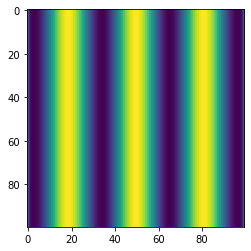

In [38]:
gx = Dx @ g
plt.imshow(gx.reshape(100,100))
plt.show()

If we want to create a numerical y derivative $\partial_y$, we can reverse the arguments of `kron`.

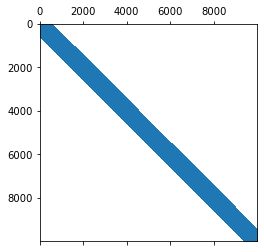

In [39]:
Dy = sparse.kron(D, sparse.eye(100)).tocsr()
plt.spy(Dy)

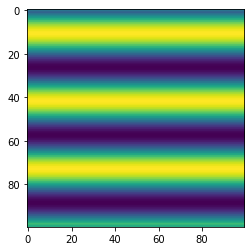

In [40]:
gy = Dy @ g
plt.imshow(gy.reshape(100,100))
plt.show()

In [49]:
col = Dx[:,220]

In [50]:
col.nonzero()

(array([219, 221], dtype=int32), array([0, 0], dtype=int32))

### Exercise: The Laplacian

Recall the Laplacian 
\begin{equation}
\Delta = \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}
\end{equation}

This comes up in modeling a variety of physical phenomena such as waves and diffusion.

1. Create a sparse matrix `L` which acts as the Laplacian on a 2-dimensional grid.  Use the second derivative stencil `[1, -2, 1]`.  use `kron`
2. Create the same matrix using `kronsum`
3. Calculate $\Delta g$, where $g(x,y) = \sin(x) + \cos(y)$, as above
4. Visualize the 4 smallest eigenvectors of the Laplacian on a $100 \times 100$ grid.

In [35]:
# Your code here
